#### Import packages 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster
import matplotlib.pyplot as plt
import folium
import matplotlib.colors as colors
from shapely import unary_union
import contextily as ctx
import libpysal as lp
import seaborn as sbn
import rioxarray as rxr
import esda 

#### Analysis region: Christchurch

<Axes: >

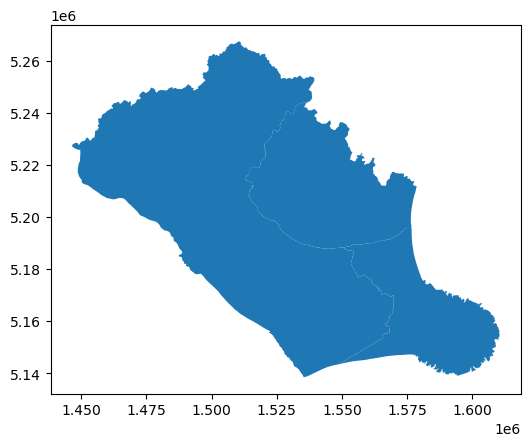

In [2]:
TA = gpd.read_file('GIS_file/territorial-authority-2021-generalised.gpkg')

dis_3 = TA.loc[TA.TA2021_V1_00_NAME.str.contains('Christchurch|Waimakariri|Selwyn'), :]

# buffer 1km
# dis_3 = dis_3

dis_3.plot()

In [3]:
# read in grid_1km_canterbury.shp
#/Users/michaeltang/Downloads/GISC412_project_repo/Canterbury_birds/GIS_file/grid_1km_canterbury.shp
grid_1km = gpd.read_file('GIS_file/grid_1km_canterbury.shp').to_crs(2193)
grid_1km = grid_1km

In [4]:
grid_1km.crs

<Projected CRS: EPSG:2193>
Name: NZGD2000 / New Zealand Transverse Mercator 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - North Island, South Island, Stewart Island - onshore.
- bounds: (166.37, -47.33, 178.63, -34.1)
Coordinate Operation:
- name: New Zealand Transverse Mercator 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

read in cbirds_gdf, this file merged with 1km grids already

In [5]:
# read in cbirds_gdf.gpkg
cbirds_gdf = gpd.read_file('GIS_file/cbirds_grid.gpkg')
cbirds_gdf.head()

,CENTROID_X,CENTROID_Y,GridID,Shape_Leng,index_right,last_edited_date,common_name,locality,migration_type,observation_count,month,geometry
0,1382500.0,5022500.0,E13825N50225,4000.0,63830,2024-01-02,New Zealand Falcon,Buster Diggings Mount Buster,N,1,1,"MULTIPOLYGON (((1382000 5023000, 1383000 50230..."
1,1378500.0,5027500.0,E13785N50275,4000.0,20725,2024-07-12,Yellowhammer,AN151,N,1,7,"MULTIPOLYGON (((1378000 5028000, 1379000 50280..."
2,1378500.0,5027500.0,E13785N50275,4000.0,20443,2024-07-12,Dunnock,AN151,N,1,7,"MULTIPOLYGON (((1378000 5028000, 1379000 50280..."
3,1378500.0,5027500.0,E13785N50275,4000.0,20723,2024-07-12,Yellowhammer,AN151,N,1,7,"MULTIPOLYGON (((1378000 5028000, 1379000 50280..."
4,1378500.0,5027500.0,E13785N50275,4000.0,20713,2024-07-12,Yellowhammer,AN151,N,1,7,"MULTIPOLYGON (((1378000 5028000, 1379000 50280..."


In [6]:
cbirds_gdf.columns

Index(['CENTROID_X', 'CENTROID_Y', 'GridID', 'Shape_Leng', 'index_right',
       'last_edited_date', 'common_name', 'locality', 'migration_type',
       'observation_count', 'month', 'geometry'],
      dtype='object')

try un sjoined birds data set to follow the lab material

In [7]:
cbird = pd.read_csv('GIS_file/cbirds_filtered.csv')
print(cbird.head())

  LAST EDITED DATE  TAXONOMIC ORDER CATEGORY          COMMON NAME  \
0       2023/01/11           6851.0     spuh        albatross sp.   
1       2023/01/11           6851.0     spuh        albatross sp.   
2       2023/12/11           7167.0  species  Australasian Gannet   
3       2023/01/18           7167.0  species  Australasian Gannet   
4       2023/10/17           7167.0  species  Australasian Gannet   

   SCIENTIFIC NAME EXOTIC CODE OBSERVATION COUNT BREEDING CODE  \
0  Diomedeidae sp.         NaN                 1           NaN   
1  Diomedeidae sp.         NaN                 4           NaN   
2   Morus serrator         NaN                 1           NaN   
3   Morus serrator         NaN                 1           NaN   
4   Morus serrator         NaN                 2           NaN   

  BREEDING CATEGORY BEHAVIOR CODE  ... ATLAS BLOCK  \
0               NaN           NaN  ...         NaN   
1               NaN           NaN  ...     blkCI59   
2               NaN       

In [8]:
cbird.columns

# covert columns to lower case
cbird.columns = cbird.columns.str.lower()


In [9]:
#Convert Lat/Long to geometry
cbird_dis_3 = gpd.GeoDataFrame(cbird, geometry=gpd.points_from_xy(cbird.longitude, cbird.latitude), crs="EPSG:4326")\
.to_crs(2193).clip(dis_3)

Select useful cols and slipt date to month

In [10]:
cbird_dis_3.columns

Index(['last edited date', 'taxonomic order', 'category', 'common name',
       'scientific name', 'exotic code', 'observation count', 'breeding code',
       'breeding category', 'behavior code', 'state code', 'county',
       'county code', 'iba code', 'atlas block', 'locality', 'locality id',
       'locality type', 'latitude', 'longitude', 'observation date',
       'time observations started', 'approved', 'migration_type', 'geometry'],
      dtype='object')

In [11]:
# add underscore to column names
cbird_dis_3.columns = cbird_dis_3.columns.str.replace(' ', '_')

In [12]:
cbird_dis_3.head(3)

,last_edited_date,taxonomic_order,category,common_name,scientific_name,exotic_code,observation_count,breeding_code,breeding_category,behavior_code,...,locality,locality_id,locality_type,latitude,longitude,observation_date,time_observations_started,approved,migration_type,geometry
59842,2023/04/07,27356.0,species,European Starling,Sturnus vulgaris,N,3,NaN,NaN,NaN,...,Rakaia Huts,L1037809,H,-43.888274,172.239661,2023/04/07,14:10:00,1.0,N,POINT (1538926.165 5140255.224)
61238,2023/04/09,7941.0,species,Swamp Harrier,Circus approximans,NaN,1,NaN,NaN,NaN,...,Rakaia Huts,L1037809,H,-43.888274,172.239661,2023/04/09,17:40:00,1.0,N,POINT (1538926.165 5140255.224)
59964,2023/04/07,599.0,species,Gray Teal,Anas gracilis,NaN,1,NaN,NaN,NaN,...,Rakaia Huts,L1037809,H,-43.888274,172.239661,2023/04/07,14:10:00,1.0,N,POINT (1538926.165 5140255.224)


In [13]:
# select only the columns we need 
cols = ['last_edited_date', 'common_name', 'locality', 'migration_type',
       'observation_count', 'geometry']

cbirds_dis_3 = cbird_dis_3[cols]

# Ensure 'last_edited_date' is in datetime format
cbirds_dis_3['last_edited_date'] = pd.to_datetime(cbirds_dis_3.loc[:,'last_edited_date'])

# split the date to month column
cbirds_dis_3['month'] = cbirds_dis_3.loc[:,'last_edited_date'].dt.month



/opt/anaconda3/envs/new_env_yml/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/new_env_yml/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
cbirds_dis_3['observation_count'].unique()

array(['3', '1', '2', '12', '20', '4', '66', '30', '6', '40', '50', '13',
       '38', '27', '28', '22', '15', '8', '10', '7', '25', '9', '39',
       '14', '32', '100', '5', '46', '19', '200', '300', '26', '24', '78',
       'X', '70', '11', '120', '35', '90', '306', '160', '36', '23', '17',
       '80', '500', '29', '21', '510', '16', '294', '250', '450', '237',
       '400', '115', '281', '31', '45', '57', '60', '37', '54', '267',
       '34', '18', '967', '67', '148', '71', '110', '547', '150', '374',
       '172', '109', '158', '41', '42', '55', '111', '900', '48', '44',
       '77', '404', '126', '523', '247', '1250', '410', '130', '470',
       '305', '52', '650', '75', '43', '61', '2000', '84', '140', '51',
       '97', '64', '187', '127', '146', '76', '62', '33', '342', '600',
       '186', '123', '1150', '350', '47', '63', '56', '598', '105', '92',
       '139', '59', '53', '104', '85', '58', '65', '49', '290', '800',
       '95', '390', '128', '671', '175', '211', '198', '42

In [15]:
cbirds_dis_3.loc[:,'observation_count'] = cbirds_dis_3['observation_count'].replace('X', '1')


In [16]:
# convert obersevation count to numeric and categorize the migration type
cbirds_dis_3['observation_count'] = cbirds_dis_3.loc[:,'observation_count'].astype('int')

cbirds_dis_3['migration_type'] = cbirds_dis_3.loc[:,'migration_type'].astype('category')

/opt/anaconda3/envs/new_env_yml/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/new_env_yml/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

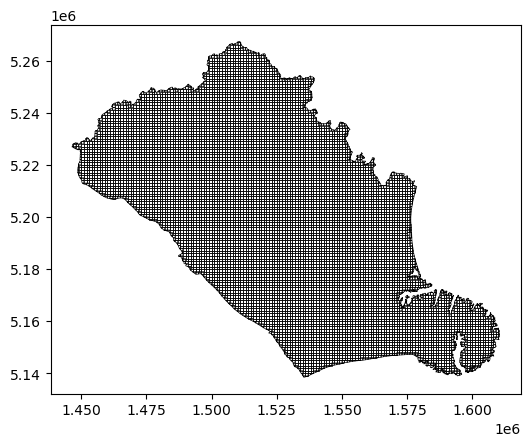

In [17]:
#Load shapefile and clip to dis_3
unit = grid_1km.clip(dis_3)

# plot the unit and highlight the grid
unit.plot(edgecolor='black', facecolor='none', linewidth=0.5)



#### split the cbirds_gdf_new into two dataframes: nbirds and nbirds by migration_type

In [18]:
# split the cbirds_gdf_new into two dataframes: nbirds and nbirds by migration_type
nbirds = cbirds_dis_3[cbirds_dis_3['migration_type'] == 'N']
mbirds = cbirds_dis_3[cbirds_dis_3['migration_type'] == 'M']
print(nbirds.shape)
print(mbirds.shape)

(47926, 7)
(502, 7)


In [19]:
# filter nbirds and mbirds by month which is (1-3)
nbirds = nbirds[nbirds['month'].isin([1,2,3])]
mbirds = mbirds[mbirds['month'].isin([1,2,3])]
print(nbirds.shape)
print(mbirds.shape)


(23915, 7)
(214, 7)


In [20]:
unit

,CENTROID_X,CENTROID_Y,GridID,Shape_Leng,geometry
11145,1535500.0,5138500.0,E15355N51385,4000.0,"POLYGON ((1536000 5139000, 1536000 5138690.181..."
11166,1534500.0,5139500.0,E15345N51395,4000.0,"POLYGON ((1535000 5140000, 1535000 5139186.138..."
11278,1535500.0,5139500.0,E15355N51395,4000.0,"POLYGON ((1536000 5140000, 1536000 5139000, 15..."
22046,1533500.0,5140500.0,E15335N51405,4000.0,"POLYGON ((1534000 5141000, 1534000 5140744.267..."
11282,1535500.0,5140500.0,E15355N51405,4000.0,"POLYGON ((1536000 5141000, 1536000 5140000, 15..."
...,...,...,...,...,...
42940,1506500.0,5265500.0,E15065N52655,4000.0,"POLYGON ((1506008.793 5265274, 1506083.196 526..."
42941,1506500.0,5266500.0,E15065N52665,4000.0,"POLYGON ((1506805.03 5266000, 1506838.918 5266..."
42942,1507500.0,5266500.0,E15075N52665,4000.0,"POLYGON ((1507002.399 5266256.213, 1507010.591..."
42953,1508500.0,5266500.0,E15085N52665,4000.0,"POLYGON ((1508038.603 5266437.32, 1508048.216 ..."


In [21]:
cbirds_dis_3.head(3)

,last_edited_date,common_name,locality,migration_type,observation_count,geometry,month
59842,2023-04-07,European Starling,Rakaia Huts,N,3,POINT (1538926.165 5140255.224),4
61238,2023-04-09,Swamp Harrier,Rakaia Huts,N,1,POINT (1538926.165 5140255.224),4
59964,2023-04-07,Gray Teal,Rakaia Huts,N,1,POINT (1538926.165 5140255.224),4


In [22]:
grid_1km.head(3)

,CENTROID_X,CENTROID_Y,GridID,Shape_Leng,geometry
0,1395500.0,5004500.0,E13955N50045,4000.0,"POLYGON ((1395000 5005000, 1395673.839 5005000..."
1,1397500.0,5005500.0,E13975N50055,4000.0,"POLYGON ((1397000 5006000, 1398000 5006000, 13..."
2,1398500.0,5005500.0,E13985N50055,4000.0,"POLYGON ((1398000 5006000, 1398315.176 5006000..."


#### Spatial join the Airbnb points data to the 1km grid.

In [23]:
from shapely import unary_union
# Spatial aggregation using spatial join

#Join airbnb to SA2 gpd and calculate median price for each SA2 unit
mbirds_nb = gpd.sjoin(mbirds, unit, how='right', predicate='intersects')\
.groupby(['GridID'])\
.agg(
    counts=("observation_count", "sum"),
    geometry = ('geometry', lambda x: unary_union(x)), 
    # convert an array of geometries into a single geometry object for each row
).reset_index() # reset the index of the resulting dataframe.

# convert pandas to geopandas
mbirds_nb = gpd.GeoDataFrame(mbirds_nb, geometry = mbirds_nb.geometry, crs = 2193)

mbirds_nb.head(5)



,GridID,counts,geometry
0,E14465N52265,0.0,"POLYGON ((1447000 5226724.191, 1446970.946 522..."
1,E14465N52275,0.0,"POLYGON ((1447000 5227000, 1446505.094 5227000..."
2,E14465N52285,0.0,"POLYGON ((1446896.087 5228000, 1446946.645 522..."
3,E14475N52265,0.0,"POLYGON ((1448000 5227000, 1448000 5226066.072..."
4,E14475N52275,0.0,"POLYGON ((1448000 5228000, 1448000 5227000, 14..."


In [24]:
mbirds_nb['counts'].unique()

array([0.000e+00, 2.100e+01, 4.600e+01, 6.000e+00, 7.500e+01, 7.090e+02,
       3.300e+01, 4.000e+00, 5.200e+01, 4.100e+01, 5.000e+00, 4.000e+01,
       3.500e+01, 5.900e+01, 1.202e+03, 1.159e+03, 2.600e+02, 1.000e+00,
       1.205e+03, 1.580e+02, 4.300e+01, 2.000e+00])

In [58]:
mbirds_nb.shape

(10718, 3)

In [25]:
pd.isnull(mbirds_nb['counts']).sum()

0

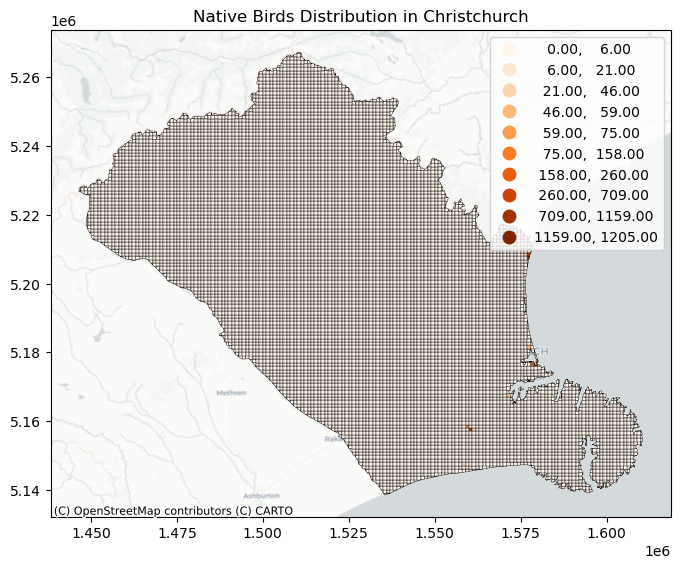

In [26]:
# map visualisation 

# add basemaps using `contextily`
import contextily as ctx

# initiate the map
fig, ax = plt.subplots(figsize=(8, 8))

# creating the map with 6 equak intervals using the 'fisherjenks' classification scheme
mbirds_nb.plot(column="counts", scheme='fisherjenks', k=10, cmap="Oranges", 
               edgecolor="black", linestyle="-", linewidth=0.3, 
               # plot the polygons with black and solid outlines
               missing_kwds={ "color": "lightgrey", "label": "Data not available"},
               # in case there are any areas with Nan - there shouldn't be in this plot but you may have some in your data if you reuse this code
               legend=True, ax=ax,)

# 

ax.set_title("Native Birds Distribution in Christchurch") # Set the title of each subplot

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

# show the plot
plt.show()

#### Spatial Autocorrelation

In [27]:
# Spatial similarity
import libpysal as lp

mbirds_nb = mbirds_nb.loc[~mbirds_nb.geom_type.isin(['Point', 'GeometryCollection']),:]
# remove Point and GeometryCollection in geometry otherwise get a TypeError

#Generate weights matrix - use_index = use index of df as ids to index the spatial weights object - we are not using this
wq =  weights.contiguity.Queen.from_dataframe(mbirds_nb, use_index=False)

#Row-standardise the weights
wq.transform = 'r'

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

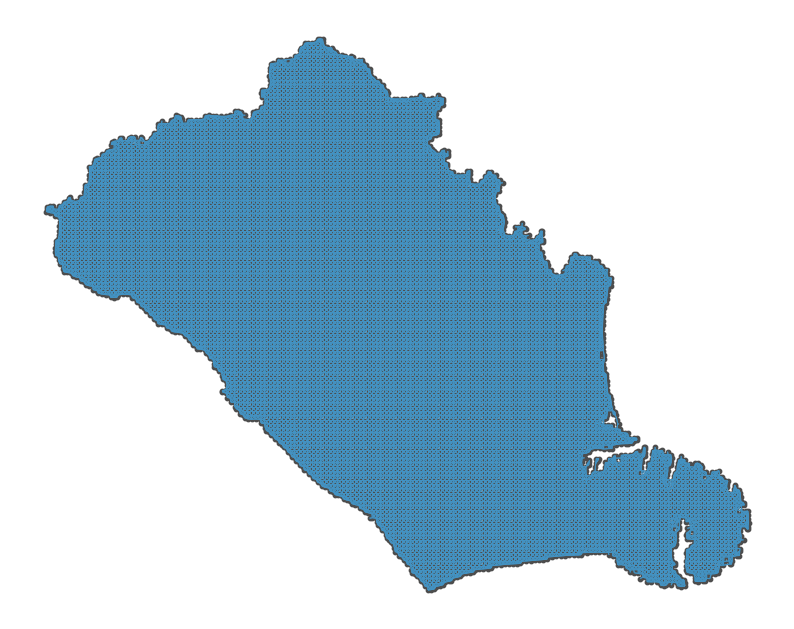

In [28]:
# Plotting to visualize spatial weights
plot_spatial_weights(wq, mbirds_nb)

In [29]:
wq.weights

{0: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 1: [0.2, 0.2, 0.2, 0.2, 0.2],
 2: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 3: [0.2, 0.2, 0.2, 0.2, 0.2],
 4: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 5: [0.2, 0.2, 0.2, 0.2, 0.2],
 6: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 7: [0.2, 0.2, 0.2, 0.2, 0.2],
 8: [0.2, 0.2, 0.2, 0.2, 0.2],
 9: [0.2, 0.2, 0.2, 0.2, 0.2],
 10: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 11: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 12: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 13: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 14: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 15: [0.3333333333333

In [30]:
wq.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 12, 13],
 4: [0, 1, 2, 3, 5, 12, 13, 14],
 5: [1, 2, 4, 13, 14],
 6: [17, 18, 7],
 7: [17, 18, 19, 6, 8],
 8: [18, 19, 20, 7, 9],
 9: [19, 20, 21, 8, 10],
 10: [9, 20, 21],
 11: [26, 27, 12],
 12: [3, 4, 27, 26, 11, 28, 13],
 13: [3, 4, 5, 27, 12, 28, 14],
 14: [13, 4, 5],
 15: [16, 33, 32],
 16: [32, 33, 17, 34, 15],
 17: [16, 33, 34, 35, 18, 6, 7],
 18: [34, 35, 36, 6, 7, 8, 17, 19],
 19: [35, 36, 37, 7, 8, 9, 18, 20],
 20: [36, 37, 38, 8, 9, 10, 19, 21],
 21: [20, 37, 38, 39, 22, 9, 10],
 22: [21, 38, 23, 39, 40],
 23: [22, 39, 40, 24, 41],
 24: [23, 40, 25, 42, 41],
 25: [26, 24, 41, 42, 43],
 26: [25, 27, 43, 42, 11, 12, 44],
 27: [43, 11, 12, 13, 44, 45, 26, 28],
 28: [13, 29, 46, 27, 12, 45, 44],
 29: [28, 45, 46],
 30: [48, 49, 31],
 31: [48, 49, 32, 50, 30],
 32: [16, 33, 49, 50, 51, 31, 15],
 33: [32, 34, 15, 16, 17, 50, 51, 52],
 34: [33, 35, 16, 17, 18, 51, 52, 53],
 35: [34, 36, 17, 18, 19, 52, 53, 54],
 36: 

### Global spatial autocorrelation

### Continuous Case

In [31]:
wq.transform = 'r'

In [32]:
#Set our variable of interest
y = mbirds_nb['counts']

In [33]:
np.random.seed(66)
mi = esda.moran.Moran(y, wq)
mi.I

0.16476072970225183

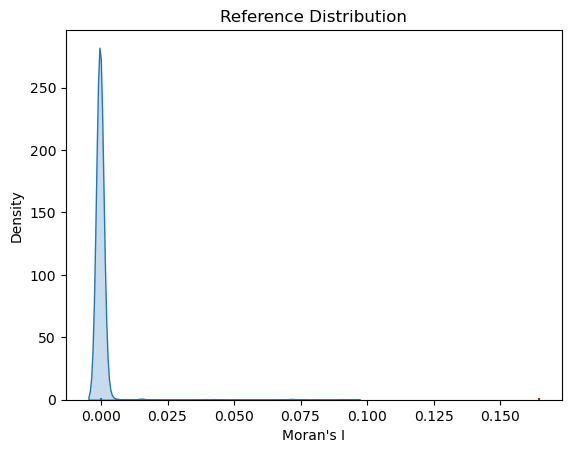

In [34]:

sbn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")
plt.title('Reference Distribution')
plt.show()

In [35]:
mi.p_sim

0.001

### Local Autocorrelation: Moran’s Plot

In [36]:
#Transform the weights matrix back to row-standardised to calculate the spatial lag price
wq.transform = 'r'
lag_counts = lp.weights.lag_spatial(wq, mbirds_nb['counts'])

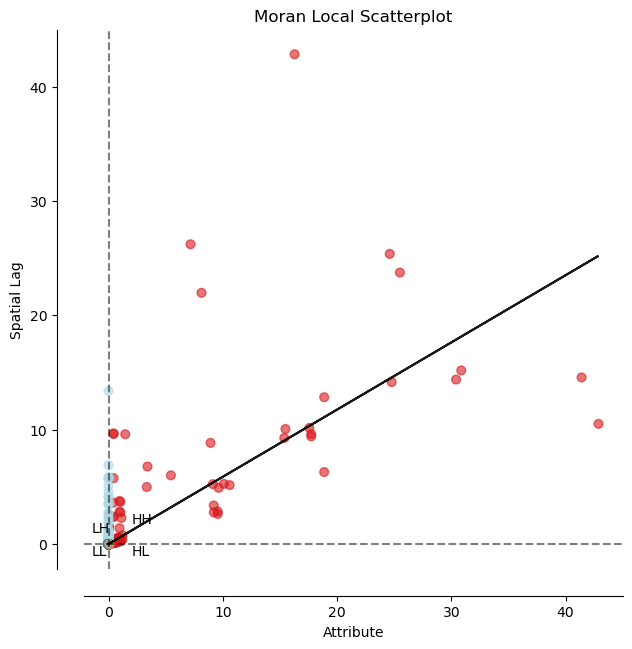

In [37]:
# Local Moran's I
local_moran = Moran_Local(lag_counts, wq)

# Plotting Local Moran's I scatterplot of pop_count
fig, ax = moran_scatterplot(local_moran, p=0.05);

plt.text(1.95, 1.8, 'HH', fontsize=10)
plt.text(1.95, -1.0, 'HL', fontsize=10)
plt.text(-1.5, 1, 'LH', fontsize=10)
plt.text(-1.5, -1, 'LL', fontsize=10)
plt.show()

In [38]:
li = esda.moran.Moran_Local(y, wq)
li.q

array([3, 3, 3, ..., 3, 3, 3])

In [39]:
(li.p_sim < 0.05).sum()

10718

### Hot Spots, Cold Spots, Doughnuts and Diamonds

In [40]:
#Create a pandas series of booleans for SA2 areas with p-values < 0.05 for each of the 4 quadrants
sig = li.p_sim < 0.01
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

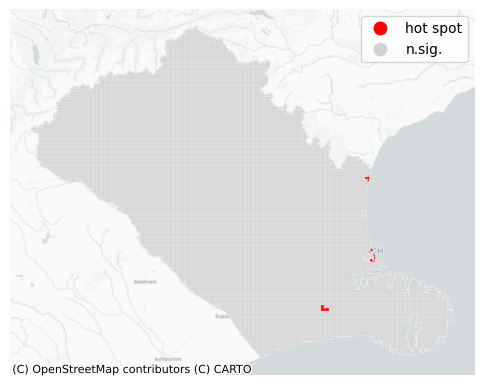

In [41]:
#Label each Hotspot
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

df = mbirds_nb

from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

plt.show()

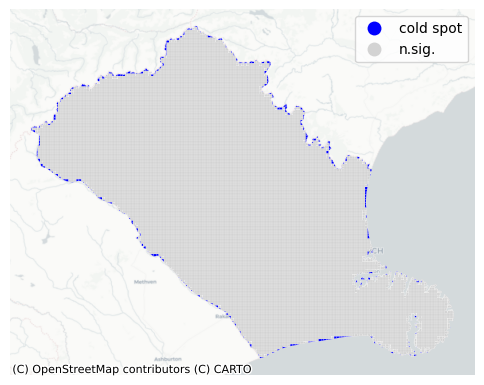

In [42]:
#Label each Cold spot
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

df = mbirds_nb

from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

plt.show()

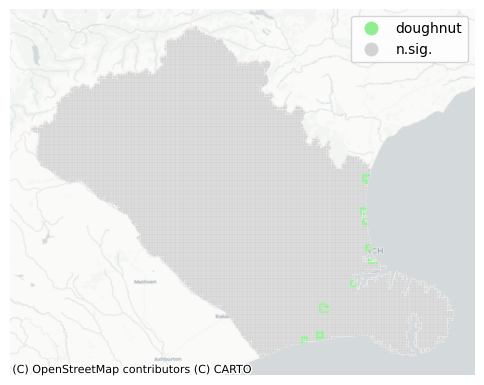

In [43]:
#Label each doughnut
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

df = df

from matplotlib import colors
hmap = colors.ListedColormap(['lightgreen', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)
plt.show()

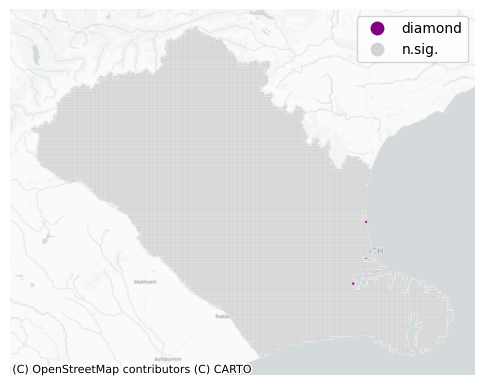

In [44]:
#Label each diamond
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

df = mbirds_nb
from matplotlib import colors
hmap = colors.ListedColormap(['purple', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)
plt.show()

In [45]:
#Create an array for SA2 areas with p-values < 0.05 for all 4 quadrants combined
sig = 1 * (li.p_sim < 0.01)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 3, ..., 0, 0, 0])

In [46]:
np.unique(spots)

array([0, 1, 2, 3, 4])

In [47]:
sig = 1 * (li.p_sim < 0.01)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 3, ..., 0, 0, 0])

In [48]:
import rioxarray as rxr

# Read the raster file (e.g., GeoTIFF)
temp_raster = rxr.open_rasterio('GIS_file/cantburry_average_temp_1.tif')

# Print the metadata and information about the raster
print(temp_raster)

# If it's a multi-band raster, you can check the number of bands:
print(f"Number of bands: {temp_raster.rio.count}")

# If it's a single-band raster, you can access the data directly:
band_data = temp_raster[1]  # Get the first band (index 0)

# View raster data shape (dimensions: bands, height, width)
print(band_data.shape)


<xarray.DataArray (band: 2, y: 611, x: 625)> Size: 6MB
[763750 values with dtype=float64]
Coordinates:
  * band         (band) int64 16B 1 2
  * x            (x) float64 5kB 1.204e+06 1.204e+06 ... 1.826e+06 1.828e+06
  * y            (y) float64 5kB 5.49e+06 5.49e+06 ... 4.882e+06 4.88e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('LST_Day_1km', 'LST_Day_Celsius')
Number of bands: 2
(611, 625)


In [49]:
# Plot the temp_raster
temp_raster.rio.crs


CRS.from_epsg(2193)

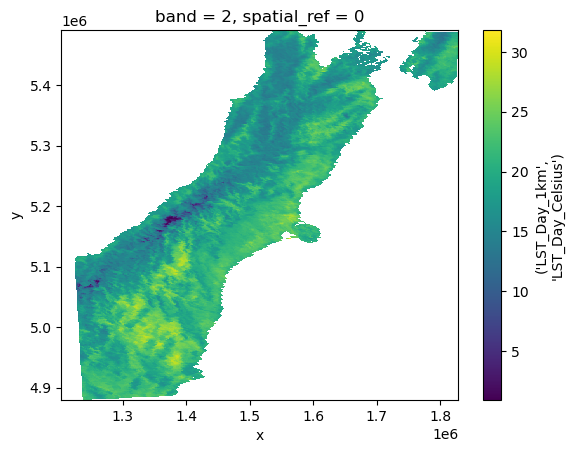

In [50]:
temp_raster[1].plot()


In [51]:
# clip cbirds_temp to dis_3
temp_degree = temp_raster[1]


In [52]:
temp_clipped = temp_degree.rio.clip(dis_3.geometry)

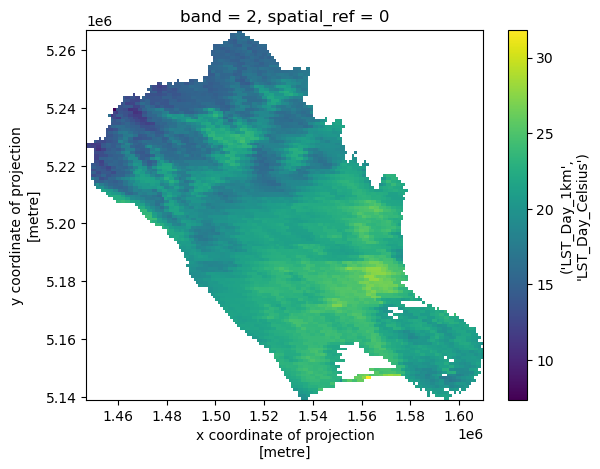

In [53]:
temp_clipped.plot()

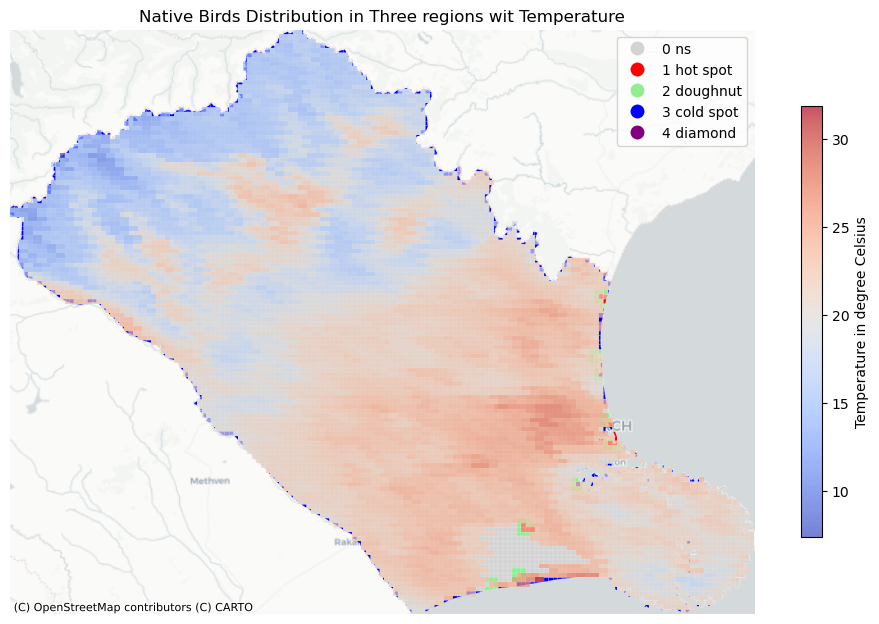

In [54]:
#Label each value in the array
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots] 

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightgreen', 'blue', 'purple'])
f, ax = plt.subplots(1, figsize=(12, 14))
mbirds_nb.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

# add the temp_mean of cbirds_temp_dis_3 to the plot
temp_plot = temp_clipped.plot(ax=ax, cmap='coolwarm', alpha=0.7, add_colorbar=False)
ax.set_title('Native Birds Distribution in Three regions wit Temperature')
cbar = plt.colorbar(temp_plot, ax=ax, orientation='vertical', shrink=0.4)

cbar.set_label('Temperature in degree Celsius')
plt.show()

import soil type shap file

import wetland_vegetation and open water habitat


<Axes: >

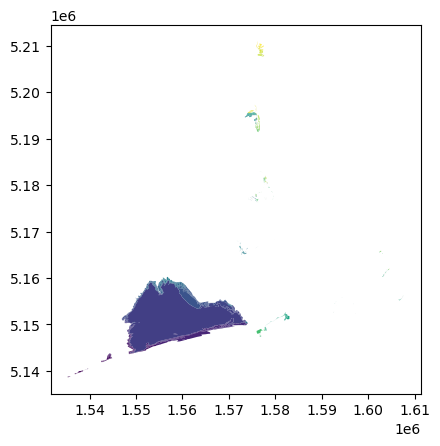

In [55]:
#import wetland shapefile
wetland = gpd.read_file('GIS_file/Canterbury_Coastal_Wetland_Vegetation___habitats.zip')

# clip wetland to dis_3
wetland_clipped = wetland.clip(dis_3.geometry)

# plot wetland_clipped
wetland_clipped.plot(cmap='viridis', legend=True)

<Axes: >

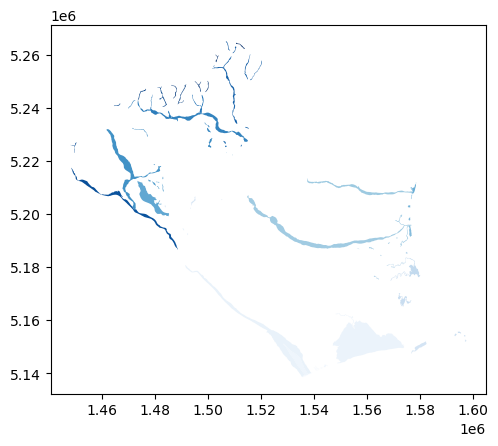

In [56]:
# import open water shapefile
open_water = gpd.read_file('GIS_file/Native_Bird_River_and_Open_Water_Habitat.zip')

# clip open_water to dis_3
open_water_clipped = open_water.clip(dis_3.geometry)

# plot open_water_clipped
open_water_clipped.plot(cmap='Blues', legend=True)

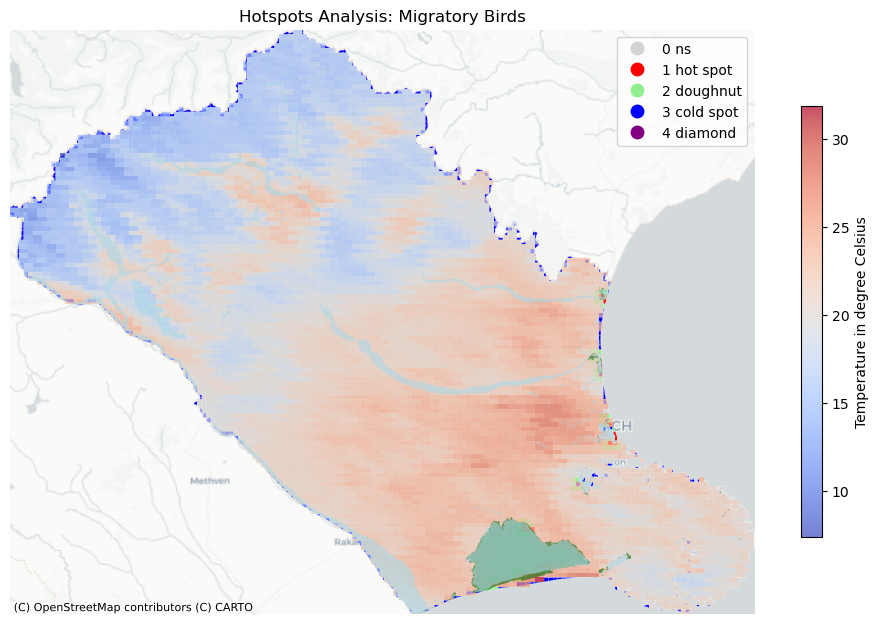

In [57]:
#Label each value in the array
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots] 

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightgreen', 'blue', 'purple'])
f, ax = plt.subplots(1, figsize=(12, 14))
mbirds_nb.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

# add the temp_mean of cbirds_temp_dis_3 to the plot
temp_plot = temp_clipped.plot(ax=ax, cmap='coolwarm', alpha=0.7, add_colorbar=False)
ax.set_title('Hotspots Analysis: Migratory Birds')
cbar = plt.colorbar(temp_plot, ax=ax, orientation='vertical', shrink=0.4)

# add the wetland_clipped to the plot
wetland_clipped.plot(ax=ax, color='darkgreen', alpha=0.6)

# add the open_water_clipped to the plot
open_water_clipped.plot(ax=ax, color='lightblue', alpha=0.6)

#soi_clipped.plot(ax=ax, cmap='viridis', alpha=0.6)

cbar.set_label('Temperature in degree Celsius')
plt.show()